### How has the predominant emotional tone changed over time within each genre? 

First lets do a general analysis of how the overall emotional tone had changed over time 

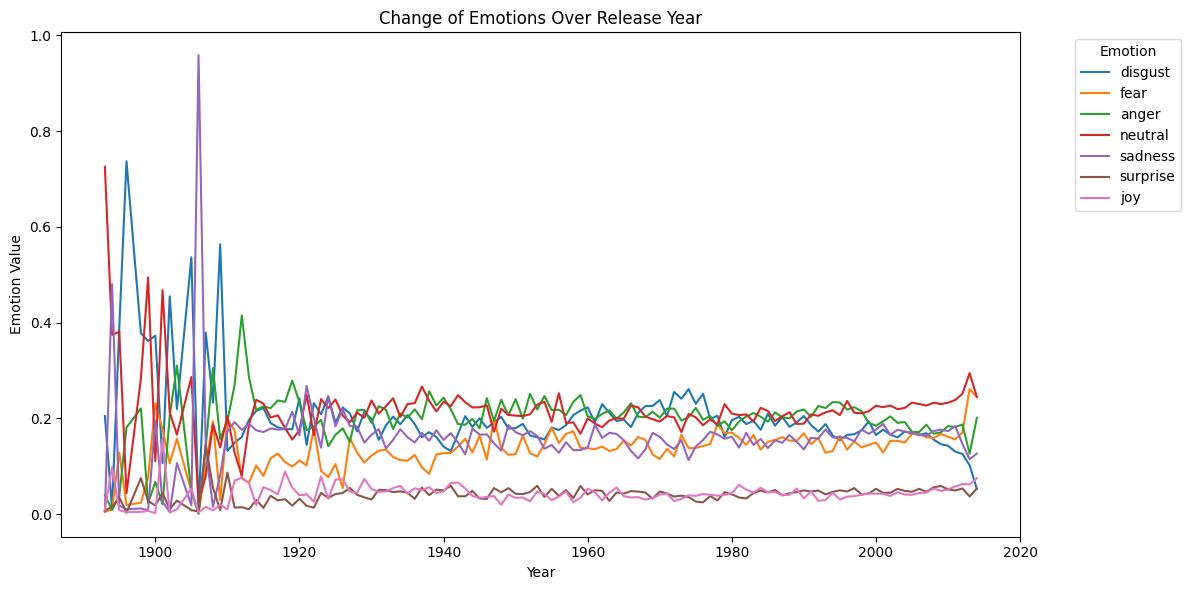

In [1]:
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import ast

sys.path.append("../")
from utils.methods import conv_to_dict

df = pd.read_csv("../../data/final_data_complete.csv")

temp = pd.DataFrame(list(df['distilbert_emotions'].apply(conv_to_dict)))

emotions_df = pd.concat([df, temp], axis=1)

emotions_df['merge_year'] = emotions_df['merge_year'].astype("Int64")


emotions = ['disgust', 'fear', 'anger', 'neutral', 'sadness', 'surprise', 'joy']

temp = emotions_df.groupby('merge_year').agg({
    emotion: ['mean'] for emotion in emotions
}).reset_index()


temp.columns = ['merge_year'] + emotions

long_df = pd.melt(temp, id_vars=["merge_year"], 
                  var_name="Emotion", 
                  value_name="Value")

plt.figure(figsize=(12, 6))
sns.lineplot(data=long_df, x="merge_year", y="Value", hue="Emotion")
plt.title("Change of Emotions Over Release Year")
plt.xlabel("Year")
plt.ylabel("Emotion Value")
plt.legend(title="Emotion", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()



##### We can a very high variance in the emotional tone in the film made prior to 1925. This can be attributed to the fact that we have very few films from that era in our dataset and the plot summaries are not enough to get a good idea of the emotional tone of the film.

##### So we decided to escude the films made prior to 1925 and focus on the films made after 1925.

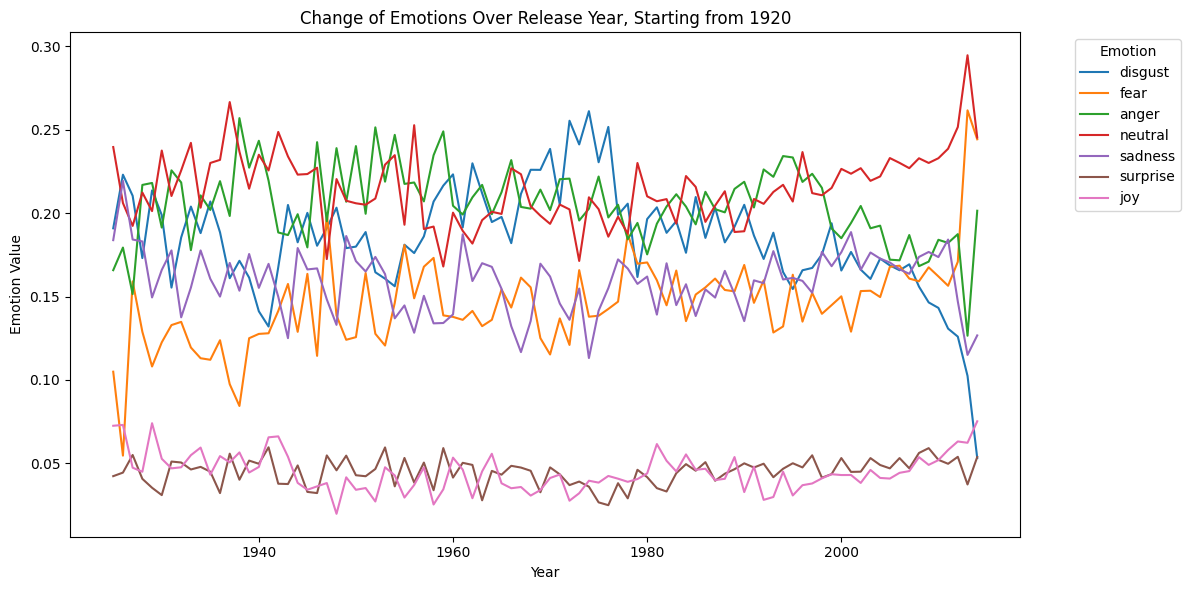

In [2]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=long_df[long_df['merge_year'] >= 1925], x="merge_year", y="Value", hue="Emotion")
plt.title("Change of Emotions Over Release Year, Starting from 1920")
plt.xlabel("Year")
plt.ylabel("Emotion Value")
plt.legend(title="Emotion", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()



##### Now the plot is way more clear, we can see emotional tones overall seems to be quite stationary over time except few exceptions.

##### That pattern seems to have change in recent years, where we see drastic changes in the most of emotions after the year 2000.

##### Lets go deeper now and see how the predominant emotions have changed over time within each genre.

In [3]:
# Import the dataset from the cleaning part of the Question 1 script
emotions_df = pd.read_csv("../../data/emotions_timeseries.csv")

emotions = ['disgust', 'fear', 'anger', 'neutral', 'sadness', 'surprise', 'joy'] 

grouped_df = emotions_df.groupby(['Genres', 'merge_year'])[emotions].mean().reset_index()

genres_emotions_mapping = {
    "Action": ["anger"],
    "Comedy": ["surprise", "joy"],
    "Crime Fiction": ["disgust", "anger"],
    "Drama": ["sadness"],
    "Family Film": ["surprise", "joy"],
    "Horror": ["fear", "disgust"],
    "Indie": ["sadness"],
    "Romance Film": ["sadness", "joy"],
    "Thriller": ["fear", "anger"],
    "World Cinema": ["sadness", "disgust"]
}

filtered_df = grouped_df[(grouped_df["Genres"].isin(genres_emotions_mapping.keys())) & (grouped_df["merge_year"] >= 1925)]
filtered_df

,Genres,merge_year,disgust,fear,anger,neutral,sadness,surprise,joy
4,Action,1925.0,0.132188,0.154740,0.532814,0.071124,0.058418,0.044134,0.006582
5,Action,1926.0,0.035848,0.007356,0.077189,0.435834,0.031534,0.015973,0.396268
6,Action,1927.0,0.057605,0.231175,0.195570,0.265462,0.227453,0.014149,0.008586
7,Action,1928.0,0.100966,0.081663,0.244840,0.138429,0.393080,0.022458,0.018564
8,Action,1929.0,0.102681,0.078894,0.397675,0.298218,0.111910,0.007414,0.003208
...,...,...,...,...,...,...,...,...,...
1411,Thriller,2009.0,0.163573,0.234907,0.220487,0.179667,0.135361,0.049603,0.016402
1412,Thriller,2010.0,0.183636,0.233520,0.264561,0.162729,0.099979,0.041078,0.014498
1413,Thriller,2011.0,0.156723,0.246248,0.242392,0.173810,0.117400,0.038581,0.024847
1414,Thriller,2012.0,0.171317,0.267541,0.244809,0.152637,0.076240,0.064708,0.022749


In [4]:
# Dividing the data into separate dataframes to separate the time series analysis 
genre_dataframes = {}

for genre, emotions in genres_emotions_mapping.items():
    genre_data = filtered_df[filtered_df["Genres"] == genre]
    genre_dataframes[genre] = genre_data[["merge_year"] + emotions].dropna()

action_df = genre_dataframes["Action"]
comedy_df = genre_dataframes["Comedy"]
crime_fiction_df = genre_dataframes["Crime Fiction"]
drama_df = genre_dataframes["Drama"]
family_film_df = genre_dataframes["Family Film"]
horror_df = genre_dataframes["Horror"]
indie_df = genre_dataframes["Indie"]
romance_film_df = genre_dataframes["Romance Film"]
thriller_df = genre_dataframes["Thriller"]
world_cinema_df = genre_dataframes["World Cinema"]

### Action movies Time Series Analysis

In [13]:
#Function for the box and jenkins procedure
import itertools
import warnings
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def box_jenkins_procedure(data: pd.DataFrame, genre: str):
    tones = data.columns[1:]
    arima_results = {}
    warnings.filterwarnings("ignore")
    for tone in tones:
        print(f"Performing Box-Jenkins Procedure for {tone} in {genre} Genre")
        series = data[tone]
        adf = adfuller(series)
        print(f"ADF Statistic: {adf[0]}")
        print(f"p-value: {adf[1]}")
        d = 0
        if adf[1] > 0.05:
            print("The series is not stationary and needs to be differenced.")
            series = series.diff().reset_index(drop=True).dropna()
            d = 1
        
        p = range(1,4) # 1,2,3
        q = range(0,3) # 0,1,2
        best_aic = np.inf
        best_order = None
        best_model = None

        for p, q in itertools.product(p,q):
            model = ARIMA(series, order=(p,d,q))
            result = model.fit()
            if result.aic < best_aic:
                best_aic = result.aic
                best_order = (p,d,q)
                best_model = result
        print(f"Best ARIMA Order for {tone} in {genre} Genre: {best_order}")
        arima_results[tone] = best_model
    return arima_results


def timeseries_plots(data: pd.DataFrame, genre: str):
    tones = data.columns[1:]
    palette = sns.color_palette("bright", len(tones))

    plt.figure(figsize=(12, 6))
    for tone, color in zip(tones, palette):
        sns.lineplot(data=data, x="merge_year", y=tone, label=tone, color= color)
    plt.title(f"{genre} Emotions Over Time")
    plt.xlabel("Year")
    plt.ylabel("Emotion Value")
    plt.legend(title="Emotion", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.grid()
    plt.show()

    for tones, color in zip(tones, palette):
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        plot_acf(action_df[tone], lags = 20, ax = axes[0], title = f"ACF of {tone} in {genre} Genre", color = color)
        plot_pacf(action_df[tone], lags = 20, ax = axes[1], title = f"PACF of {tone} in {genre} Genre", color = color)

        axes[0].lines[0].set_color(color)  
        axes[1].lines[0].set_color(color)
        plt.tight_layout()
        plt.show()
    

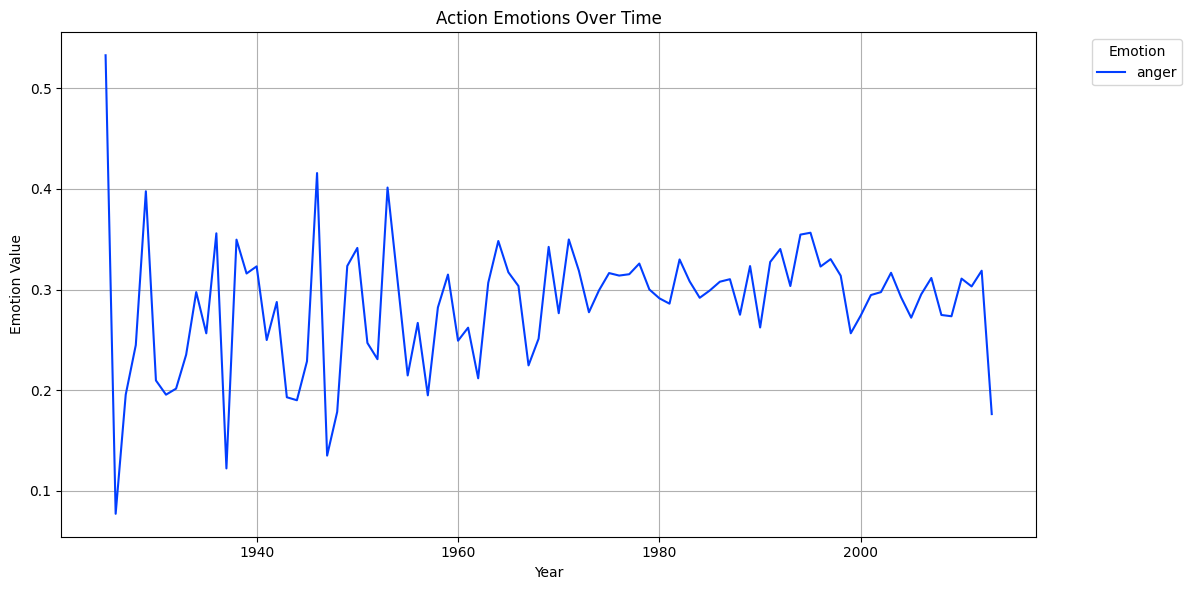

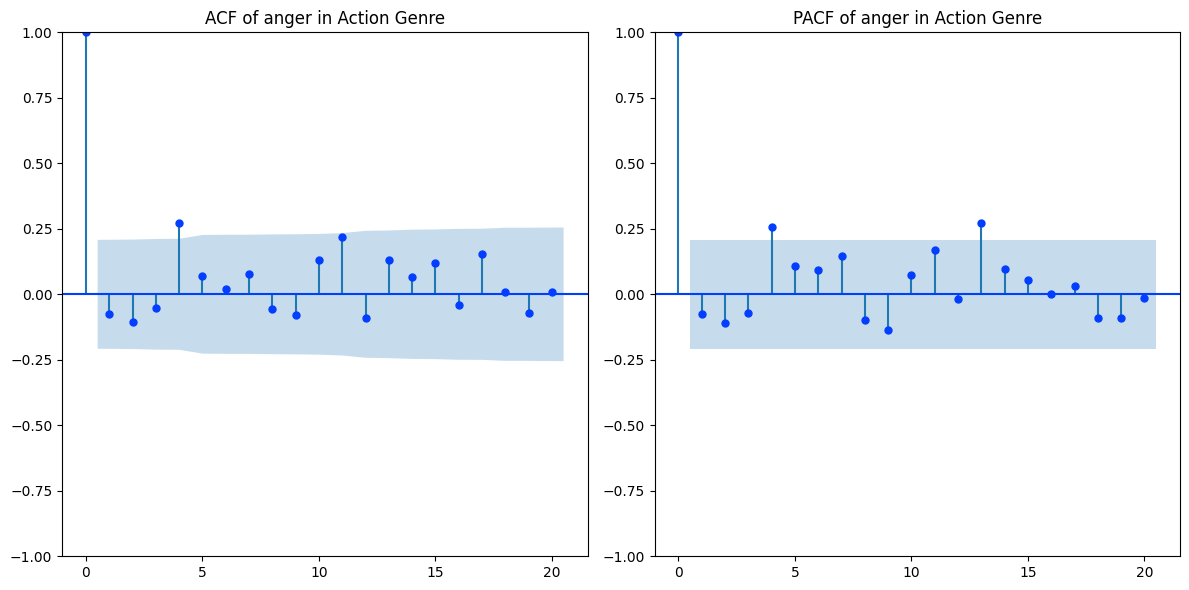

Performing Box-Jenkins Procedure for anger in Action Genre
ADF Statistic: -1.807989029390175
p-value: 0.37650263791708827
The series is not stationary and needs to be differenced.
Best ARIMA Order for anger in Action Genre: (3, 1, 2)


In [14]:

timeseries_plots(action_df, "Action")

action_ts_results = box_jenkins_procedure(action_df, "Action")


In [12]:
action_ts_results['anger'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  anger   No. Observations:                   88
Model:                 ARIMA(3, 1, 2)   Log Likelihood                 114.059
Date:                Tue, 10 Dec 2024   AIC                           -216.118
Time:                        14:54:48   BIC                           -201.322
Sample:                             0   HQIC                          -210.160
                                 - 88                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4074      0.112     -3.642      0.000      -0.627      -0.188
ar.L2         -0.3995      0.107     -3.720      0.000      -0.610      -0.189
ar.L3         -0.3920      0.101     -3.887      0.000      -0.590      -0.194
ma.L1         -1.7322      0.968     -1.790      0.073      -3.629       0.164
ma.L2          0.7330      0.699      1.049      0.294      -0.636       2.102
sigma2         0.0038      0.004      1.012      0.312      -0.004       0.011
===================================================================================
Ljung-Box (L1) (Q):                   7.11   Jarque-Bera (JB):                 7.90
Prob(Q):                              0.01   Prob(JB):                         0.02
Heteroskedasticity (H):               0.20   Skew:                             0.54
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Comedy movies Time Series Analysis